In [183]:
import os
import sys
import math
import sklearn
import matplotlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import statsmodels.api as sm


from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.utils.validation import column_or_1d
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Paths

In [184]:
CSV_PATH = "complete-frame.csv"
CSV_MINER_PATH = "testminereffectiveness.csv"

# Load All the data

In [185]:
def label_rename (row):
    return row['path_test'].split('/')[len(row['path_test'].split('/')) - 1].split('.')[0]

def load_frame():
    frame1 = pd.read_csv(CSV_PATH, sep=",")
    frame1 = frame1.sample(frac=1).reset_index(drop=True)
    frame1['TestClassName'] = frame1.apply(lambda row: label_rename(row), axis=1)
    frame2 = pd.read_csv(CSV_MINER_PATH, sep=',')
    frame = pd.merge(frame1, frame2, on='TestClassName')
    frame = frame.drop(['project', 'module', 'path_test','test_name','path_src',
                        'class_name','TestClassName','commit','Nº','Project'], axis=1)
    frame = frame.sample(frac=1).reset_index(drop=True)
    frame = frame.dropna()

    return frame

def load_frame_with_projects():
    frame1 = pd.read_csv(CSV_PATH, sep=",")
    frame1 = frame1.sample(frac=1).reset_index(drop=True)
    frame1['TestClassName'] = frame1.apply(lambda row: label_rename(row), axis=1)
    frame2 = pd.read_csv(CSV_MINER_PATH, sep=',')
    frame = pd.merge(frame1, frame2, on='TestClassName')
    frame = frame.drop(['module', 'path_test','test_name','path_src',
                        'class_name','TestClassName','commit','Nº','Project'], axis=1)
    frame = frame.sample(frac=1).reset_index(drop=True)
    frame = frame.dropna()

    return frame


def load_static_frame():
    frame1 = pd.read_csv(CSV_PATH, sep=",")
    frame1 = frame1.sample(frac=1).reset_index(drop=True)
    frame1['TestClassName'] = frame1.apply(lambda row: label_rename(row), axis=1)
    frame2 = pd.read_csv(CSV_MINER_PATH, sep=',')
    frame = pd.merge(frame1, frame2, on='TestClassName')
    frame = frame.drop(['project', 'module', 'path_test','test_name','path_src',
                        'class_name','TestClassName','commit','Nº','Project'], axis=1)
    frame = frame.sample(frac=1).reset_index(drop=True)
    frame = frame.dropna()

    return frame


def load_quartile(frame):
    low, high = frame.mutation.quantile([0.25,0.75])
    frame_low = frame.query('mutation<{low}'.format(low=low))
    frame_high = frame.query('mutation>{high}'.format(high=high))
    frame_low['mutation'] = 0
    frame_high['mutation'] = 1
    frame = pd.concat([frame_low, frame_high], ignore_index=True)
    frame = frame.sample(frac=1).reset_index(drop=True)
    return frame;

def load_meaningful_subset(frame):
    columns = [frame.no_mutations,
                         frame.line_coverage,
                         frame.csm_FE,
                         frame.CONNECTIVITY_prod,
                         frame.CONNECTIVITY_test,
                         frame.isEagerTest,
                         frame.LOC_prod, frame.LOC_test, frame.WMC_prod,
                         frame.LCOM1_prod, frame.LCOM2_prod,
                         frame.LCOM4_prod, frame.McCABE_prod,
                         frame.RFC_prod, frame.MPC_prod,
                         frame.RFC_test, frame.MPC_test,
                         frame.LCOM1_test, frame.LCOM2_test,
                         frame.LCOM4_test, frame.LCC_test,
                         frame.LCC_test, frame.WMC_test,
                         frame.McCABE_test, frame.NOP_prod]
    
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)


def load_meaningful_subset_static(frame):
    columns = [frame.no_mutations,
                         frame.csm_FE,
                         frame.CONNECTIVITY_prod,
                         frame.CONNECTIVITY_test,
                         frame.isEagerTest,
                         frame.LOC_prod, frame.LOC_test, frame.WMC_prod,
                         frame.LCOM1_prod, frame.LCOM2_prod,
                         frame.LCOM4_prod, frame.McCABE_prod,
                         frame.RFC_prod, frame.MPC_prod,
                         frame.RFC_test, frame.MPC_test,
                         frame.LCOM1_test, frame.LCOM2_test,
                         frame.LCOM4_test, frame.LCC_test,
                         frame.LCC_test, frame.WMC_test,
                         frame.McCABE_test, frame.NOP_prod]
    
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)

def load_meaningful_subset_2(frame):
    #columns = [frame.line_coverage, frame.isAssertionRoulette, frame.isMysteryGuest,
    #   frame.isResourceOptimism, frame.isForTestersOnly, frame.COH_prod, frame.BUSWEIMER_prod,
    #   frame.BUSWEIMER_test, frame.csm_LM, frame.prod_readability]
    
    [frame.line_coverage,
    frame.COH_prod, frame.BUSWEIMER_prod, frame.csm_MC,
       frame.prod_readability, frame.prod_readability]
    
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)




def load_all_data(frame):
    columns = [frame.no_mutations, frame.line_coverage, frame.isAssertionRoulette, frame.isEagerTest, frame.isLazyTest,
frame.isMysteryGuest, frame.isSensitiveEquality, frame.isResourceOptimism, frame.isForTestersOnly,
frame.isIndirectTesting, frame.LOC_prod, frame.HALSTEAD_prod, frame.RFC_prod, frame.CBO_prod, frame.MPC_prod, frame.IFC_prod, frame.DAC_prod,frame.DAC2_prod, frame.LCOM1_prod, frame.LCOM2_prod,
frame.LCOM3_prod, frame.LCOM4_prod, frame.CONNECTIVITY_prod, frame.LCOM5_prod, frame.COH_prod, frame.TCC_prod,
frame.LCC_prod, frame.ICH_prod, frame.WMC_prod, frame.NOA_prod, frame.NOPA_prod, frame.NOP_prod,
frame.McCABE_prod, frame.BUSWEIMER_prod, frame.LOC_test, frame.HALSTEAD_test, frame.RFC_test, frame.CBO_test,
frame.MPC_test, frame.IFC_test, frame.DAC_test, frame.DAC2_test, frame.LCOM1_test, frame.LCOM2_test,
frame.LCOM3_test, frame.LCOM4_test, frame.CONNECTIVITY_test, frame.LCOM5_test, frame.COH_test, frame.TCC_test,
frame.LCC_test, frame.ICH_test, frame.WMC_test, frame.NOA_test, frame.NOPA_test, frame.NOP_test, frame.McCABE_test,
frame.BUSWEIMER_test, frame.csm_CDSBP, frame.csm_CC, frame.csm_FD, frame.csm_Blob, frame.csm_SC, frame.csm_MC,
frame.csm_LM, frame.csm_FE, frame.prod_readability, frame.test_readability]
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)
    

def load_all_data_with_mine(frame):
    columns = [frame.no_mutations, frame.line_coverage, frame.isAssertionRoulette, frame.isEagerTest, frame.isLazyTest,
frame.isMysteryGuest, frame.isSensitiveEquality, frame.isResourceOptimism, frame.isForTestersOnly,
frame.isIndirectTesting, frame.LOC_prod, frame.HALSTEAD_prod, frame.RFC_prod, frame.CBO_prod, frame.MPC_prod, frame.IFC_prod, frame.DAC_prod,frame.DAC2_prod, frame.LCOM1_prod, frame.LCOM2_prod,
frame.LCOM3_prod, frame.LCOM4_prod, frame.CONNECTIVITY_prod, frame.LCOM5_prod, frame.COH_prod, frame.TCC_prod,
frame.LCC_prod, frame.ICH_prod, frame.WMC_prod, frame.NOA_prod, frame.NOPA_prod, frame.NOP_prod,
frame.McCABE_prod, frame.BUSWEIMER_prod, frame.LOC_test, frame.HALSTEAD_test, frame.RFC_test, frame.CBO_test,
frame.MPC_test, frame.IFC_test, frame.DAC_test, frame.DAC2_test, frame.LCOM1_test, frame.LCOM2_test,
frame.LCOM3_test, frame.LCOM4_test, frame.CONNECTIVITY_test, frame.LCOM5_test, frame.COH_test, frame.TCC_test,
frame.LCC_test, frame.ICH_test, frame.WMC_test, frame.NOA_test, frame.NOPA_test, frame.NOP_test, frame.McCABE_test,
frame.BUSWEIMER_test, frame.csm_CDSBP, frame.csm_CC, frame.csm_FD, frame.csm_Blob, frame.csm_SC, frame.csm_MC,
frame.csm_LM, frame.csm_FE, frame.prod_readability, frame.test_readability,frame.Assrtions, frame.Conditions,frame.TryCatch, frame.Loop,frame.Hamcrest,frame.Mockito,
           frame.BadApi,frame.LOC,frame.Expressions, frame.Depth, frame.Vocabulary,
           frame.Understandability,frame.BodySize, frame.Dexterity, frame.NonWhiteCharacters]
    
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)


def load_all_data_static(frame):
    columns = [frame.no_mutations, frame.isAssertionRoulette, frame.isEagerTest, frame.isLazyTest,
frame.isMysteryGuest, frame.isSensitiveEquality, frame.isResourceOptimism, frame.isForTestersOnly,
frame.isIndirectTesting, frame.LOC_prod, frame.HALSTEAD_prod, frame.RFC_prod, frame.CBO_prod, frame.MPC_prod, frame.IFC_prod, frame.DAC_prod,frame.DAC2_prod, frame.LCOM1_prod, frame.LCOM2_prod,
frame.LCOM3_prod, frame.LCOM4_prod, frame.CONNECTIVITY_prod, frame.LCOM5_prod, frame.COH_prod, frame.TCC_prod,
frame.LCC_prod, frame.ICH_prod, frame.WMC_prod, frame.NOA_prod, frame.NOPA_prod, frame.NOP_prod,
frame.McCABE_prod, frame.BUSWEIMER_prod, frame.LOC_test, frame.HALSTEAD_test, frame.RFC_test, frame.CBO_test,
frame.MPC_test, frame.IFC_test, frame.DAC_test, frame.DAC2_test, frame.LCOM1_test, frame.LCOM2_test,
frame.LCOM3_test, frame.LCOM4_test, frame.CONNECTIVITY_test, frame.LCOM5_test, frame.COH_test, frame.TCC_test,
frame.LCC_test, frame.ICH_test, frame.WMC_test, frame.NOA_test, frame.NOPA_test, frame.NOP_test, frame.McCABE_test,
frame.BUSWEIMER_test, frame.csm_CDSBP, frame.csm_CC, frame.csm_FD, frame.csm_Blob, frame.csm_SC, frame.csm_MC,
frame.csm_LM, frame.csm_FE, frame.prod_readability, frame.test_readability]
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)
    

def load_all_data_with_mine_static(frame):
    columns = [frame.no_mutations, frame.isAssertionRoulette, frame.isEagerTest, frame.isLazyTest,
frame.isMysteryGuest, frame.isSensitiveEquality, frame.isResourceOptimism, frame.isForTestersOnly,
frame.isIndirectTesting, frame.LOC_prod, frame.HALSTEAD_prod, frame.RFC_prod, frame.CBO_prod, frame.MPC_prod, frame.IFC_prod, frame.DAC_prod,frame.DAC2_prod, frame.LCOM1_prod, frame.LCOM2_prod,
frame.LCOM3_prod, frame.LCOM4_prod, frame.CONNECTIVITY_prod, frame.LCOM5_prod, frame.COH_prod, frame.TCC_prod,
frame.LCC_prod, frame.ICH_prod, frame.WMC_prod, frame.NOA_prod, frame.NOPA_prod, frame.NOP_prod,
frame.McCABE_prod, frame.BUSWEIMER_prod, frame.LOC_test, frame.HALSTEAD_test, frame.RFC_test, frame.CBO_test,
frame.MPC_test, frame.IFC_test, frame.DAC_test, frame.DAC2_test, frame.LCOM1_test, frame.LCOM2_test,
frame.LCOM3_test, frame.LCOM4_test, frame.CONNECTIVITY_test, frame.LCOM5_test, frame.COH_test, frame.TCC_test,
frame.LCC_test, frame.ICH_test, frame.WMC_test, frame.NOA_test, frame.NOPA_test, frame.NOP_test, frame.McCABE_test,
frame.BUSWEIMER_test, frame.csm_CDSBP, frame.csm_CC, frame.csm_FD, frame.csm_Blob, frame.csm_SC, frame.csm_MC,
frame.csm_LM, frame.csm_FE, frame.prod_readability, frame.test_readability,frame.Assrtions, frame.Conditions,frame.TryCatch, frame.Loop,frame.Hamcrest,frame.Mockito,
           frame.BadApi,frame.LOC,frame.Expressions, frame.Depth, frame.Vocabulary,
           frame.Understandability,frame.BodySize, frame.Dexterity, frame.NonWhiteCharacters]
    
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)

def load_mine(frame):
    columns = [frame.Assrtions, frame.Conditions,frame.TryCatch, frame.Loop,frame.Hamcrest,frame.Mockito,
           frame.BadApi,frame.LOC,frame.Expressions, frame.Depth, frame.Vocabulary,
           frame.Understandability,frame.BodySize, frame.Dexterity, frame.NonWhiteCharacters, frame.mutation]
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)

# Grid - Static with all their data + my data

In [6]:
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam', activation='linear', init_mode='uniform', dropout_rate=0.1):
    model = keras.Sequential()
    model.add(keras.layers.Dropout(dropout_rate, input_shape=(82,)))
    model.add(keras.layers.Dense(40, kernel_initializer=init_mode, activation=activation))
    model.add(keras.layers.Dense(20, kernel_initializer=init_mode, activation=activation))
    model.add(keras.layers.Dense(2, kernel_initializer=init_mode, activation='softmax'))

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# load dataset
frame = load_frame()
frame = load_quartile(frame)

data_x, data_y, number_of_features = load_all_data_with_mine_static(frame)

data_x = data_x.values
data_y = data_y.values

scaler = StandardScaler()
scaler.fit(data_x)
data_x = scaler.transform(data_x)


early_stopping_monitor = keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.0003, patience=10, verbose=0, mode='max', restore_best_weights=True)

model = KerasClassifier(build_fn=create_model, verbose=0, epochs=2000)

# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
dropout_rate = [0.2, 0.25, 0.3]
param_grid = dict(batch_size=batch_size, optimizer=optimizer, activation=activation, dropout_rate=dropout_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=kfold, verbose=2)
grid_result = grid.fit(data_x, data_y, callbacks=[early_stopping_monitor])
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 1008 candidates, totalling 10080 fits
[CV] activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD, total=   5.6s
[CV] activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV]  activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD, total=   3.4s
[CV] activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD, total=   3.4s
[CV] activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD, total=   3.9s
[CV] activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD, total=   5.0s
[CV] activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD, total=   3.4s
[CV] activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD, total=   7.3s
[CV] activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD 
[CV]  activation=softmax, batch_si

KeyboardInterrupt: 

# Grid - predict the exact mutation score value (Dynamic)

In [ ]:
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam', activation='linear', init_mode='uniform', dropout_rate=0.1):
    model = keras.Sequential()
    model.add(keras.layers.Dropout(dropout_rate, input_shape=(82,)))
    model.add(keras.layers.Dense(40, kernel_initializer=init_mode, activation=activation))
    model.add(keras.layers.Dense(20, kernel_initializer=init_mode, activation=activation))
    model.add(keras.layers.Dense(2, kernel_initializer=init_mode, activation='softmax'))

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# load dataset
frame = load_frame()
frame = load_quartile(frame)

data_x, data_y, number_of_features = load_all_data_with_mine(frame)

data_x = data_x.values
data_y = data_y.values

scaler = StandardScaler()
scaler.fit(data_x)
data_x = scaler.transform(data_x)


early_stopping_monitor = keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.0003, patience=10, verbose=0, mode='max', restore_best_weights=True)

model = KerasClassifier(build_fn=create_model, verbose=0, epochs=2000)

# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
dropout_rate = [0.2, 0.25, 0.3]
param_grid = dict(batch_size=batch_size, optimizer=optimizer, activation=activation, dropout_rate=dropout_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)



grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=kfold, verbose=2)
grid_result = grid.fit(data_x, data_y, callbacks=[early_stopping_monitor])
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

,mutation,no_mutations,line_coverage,isAssertionRoulette,isEagerTest,isLazyTest,isMysteryGuest,isSensitiveEquality,isResourceOptimism,isForTestersOnly,...,Mockito,BadApi,LOC,Expressions,Depth,Vocabulary,Understandability,BodySize,Dexterity,NonWhiteCharacters
0,0.960591,203,1.000000,1,1,0,0,1,0,0,...,0.0,0.0,757.0,1316.0,9.0,81.0,11284.0,1410.0,3.0,12516.0
1,0.666667,6,1.000000,1,0,0,1,0,0,0,...,0.0,0.0,1520.0,4113.0,27.0,240.0,69372.0,6332.0,2.0,31106.0
2,0.453172,331,0.560606,1,1,0,0,1,0,0,...,0.0,0.0,287.0,520.0,10.0,44.0,4461.0,666.0,3.0,3026.0
3,0.700000,70,0.848485,1,1,0,0,0,0,0,...,0.0,1.0,126.0,321.0,15.0,45.0,3206.0,427.0,2.0,2359.0
4,0.296651,209,0.424779,1,1,0,0,0,0,0,...,0.0,17.0,174.0,361.0,8.0,42.0,3310.0,451.0,3.0,2828.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2240,0.179487,117,0.316667,1,1,0,0,0,0,0,...,0.0,8.0,100.0,198.0,8.0,25.0,1779.0,254.0,3.0,1591.0
2241,1.000000,3,1.000000,1,0,0,0,0,0,0,...,0.0,0.0,43.0,154.0,25.0,41.0,3397.0,269.0,2.0,1307.0
2242,0.967742,31,1.000000,1,1,0,0,0,0,0,...,0.0,0.0,363.0,631.0,13.0,53.0,6472.0,879.0,5.0,6046.0
2243,0.602273,88,1.000000,1,1,0,0,0,0,0,...,0.0,0.0,338.0,546.0,18.0,52.0,7641.0,838.0,2.0,4274.0


In [103]:
load_all_data_with_mine(load_frame())

(      no_mutations  line_coverage  isAssertionRoulette  isEagerTest  \
 0              176           0.95                    0            0   
 1              165           1.00                    0            0   
 2              147           0.68                    1            1   
 3                6           1.00                    1            0   
 4             1187           1.00                    0            0   
 ...            ...            ...                  ...          ...   
 2240           164           0.94                    0            1   
 2241           100           0.78                    1            0   
 2242          4379           0.09                    1            1   
 2243           255           0.86                    0            1   
 2244            23           1.00                    1            1   
 
       isLazyTest  isMysteryGuest  isSensitiveEquality  isResourceOptimism  \
 0              0               0                    0  

(1570, 83)
Train on 1570 samples, validate on 336 samples
Epoch 1/1000
1570/1570 [==============================] - 2s 2ms/sample - loss: 0.1349 - mae: 0.2682 - val_loss: 0.0868 - val_mae: 0.2144
Epoch 2/1000
1570/1570 [==============================] - 0s 170us/sample - loss: 0.0418 - mae: 0.1597 - val_loss: 0.0814 - val_mae: 0.1732
Epoch 3/1000
1570/1570 [==============================] - 0s 159us/sample - loss: 0.0283 - mae: 0.1293 - val_loss: 0.0675 - val_mae: 0.1617
Epoch 4/1000
1570/1570 [==============================] - 0s 146us/sample - loss: 0.0208 - mae: 0.1101 - val_loss: 0.0648 - val_mae: 0.1577
Epoch 5/1000
1570/1570 [==============================] - 0s 148us/sample - loss: 0.0173 - mae: 0.0992 - val_loss: 0.0550 - val_mae: 0.1491
Epoch 6/1000
1570/1570 [==============================] - 0s 149us/sample - loss: 0.0150 - mae: 0.0905 - val_loss: 0.0533 - val_mae: 0.1465
Epoch 7/1000
1570/1570 [==============================] - 0s 144us/sample - loss: 0.0130 - mae: 0.0839 -

Epoch 59/1000
1570/1570 [==============================] - 0s 156us/sample - loss: 0.0023 - mae: 0.0306 - val_loss: 0.0413 - val_mae: 0.1284
Epoch 60/1000
1570/1570 [==============================] - 0s 156us/sample - loss: 0.0021 - mae: 0.0286 - val_loss: 0.0413 - val_mae: 0.1269
Epoch 61/1000
1570/1570 [==============================] - 0s 152us/sample - loss: 0.0018 - mae: 0.0298 - val_loss: 0.0382 - val_mae: 0.1267
Epoch 62/1000
1570/1570 [==============================] - 0s 150us/sample - loss: 0.0014 - mae: 0.0271 - val_loss: 0.0421 - val_mae: 0.1290
Epoch 63/1000
1570/1570 [==============================] - 0s 149us/sample - loss: 0.0016 - mae: 0.0289 - val_loss: 0.0365 - val_mae: 0.1272
Epoch 64/1000
1570/1570 [==============================] - 0s 149us/sample - loss: 0.0014 - mae: 0.0262 - val_loss: 0.0416 - val_mae: 0.1258
Epoch 65/1000
1570/1570 [==============================] - 0s 161us/sample - loss: 0.0010 - mae: 0.0230 - val_loss: 0.0362 - val_mae: 0.1251
Epoch 66/1000

1570/1570 [==============================] - 0s 157us/sample - loss: 8.0084e-04 - mae: 0.0197 - val_loss: 0.0373 - val_mae: 0.1207
Epoch 117/1000
1570/1570 [==============================] - 0s 162us/sample - loss: 0.0022 - mae: 0.0337 - val_loss: 0.0363 - val_mae: 0.1199
Epoch 118/1000
1570/1570 [==============================] - 0s 160us/sample - loss: 0.0015 - mae: 0.0285 - val_loss: 0.0380 - val_mae: 0.1192
Epoch 119/1000
1570/1570 [==============================] - 0s 169us/sample - loss: 0.0012 - mae: 0.0256 - val_loss: 0.0352 - val_mae: 0.1189
Epoch 120/1000
1570/1570 [==============================] - 0s 168us/sample - loss: 0.0014 - mae: 0.0269 - val_loss: 0.0349 - val_mae: 0.1218
Epoch 121/1000
1570/1570 [==============================] - 0s 157us/sample - loss: 0.0016 - mae: 0.0271 - val_loss: 0.0345 - val_mae: 0.1176
Epoch 122/1000
1570/1570 [==============================] - 0s 157us/sample - loss: 0.0012 - mae: 0.0248 - val_loss: 0.0366 - val_mae: 0.1182
Epoch 123/1000
15

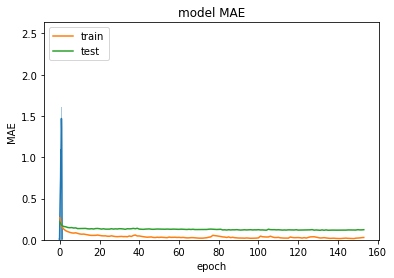

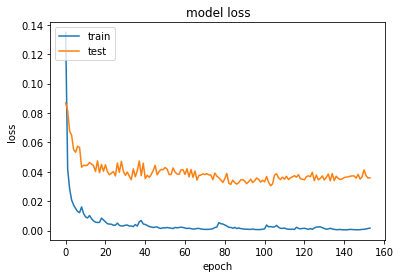

Model Accuracy: 0.11115711182355881
Overfit checks:
Model Accuracy: 0.0364975668489933


In [226]:
def silent_evaluation(model, x_test, y_test):
    f = open('/dev/null', 'w')
    regular_stdout = sys.stdout
    sys.stdout = f
    test_loss, test_acc = model.evaluate(x_test, y_test)
    sys.stdout = regular_stdout
    print('Model Accuracy: {}'.format(test_acc))
    
def split_data(train_x, train_y, training=0.70, validation=0.5):
    train_size = training

    train_cnt = math.floor(train_x.shape[0] * train_size)
    x_train = train_x[0:train_cnt]
    y_train = train_y[0:train_cnt]
    x_test = train_x[train_cnt:]
    y_test = train_y[train_cnt:]

    division = validation

    train_cnt = math.floor(x_test.shape[0] * division)
    x_validate = x_test[0:train_cnt]
    y_validate = y_test[0:train_cnt]
    x_test = x_test[train_cnt:]
    y_test = y_test[train_cnt:]

    return x_train, y_train, x_test, y_test, x_validate, y_validate    

frame = load_frame()
data_x, data_y, number_of_features = load_all_data_with_mine(frame) #load_meaningful_subset(frame)
data_y = pd.concat([frame.mutation], axis = 1).round(2).values


scaler = StandardScaler()
scaler.fit(data_x)
data_x = scaler.transform(data_x)

sns.distplot(data_y);


x_train, y_train, x_test, y_test, x_validate, y_validate = split_data(data_x, data_y)

print(x_train.shape)
model = keras.Sequential()
model.add(keras.layers.Dense(number_of_features, activation='relu', input_dim=number_of_features))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(20, activation='relu'))
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

early_stopping_monitor = keras.callbacks.EarlyStopping(patience=50,restore_best_weights=True)


history = model.fit(x_train, y_train, epochs=1000, verbose=1, validation_data=(x_validate, y_validate),
                    callbacks=[early_stopping_monitor])


# summarize history for accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

silent_evaluation(model, x_test, y_test)


print("Overfit checks:")
silent_evaluation(model, x_train, y_train)

In [227]:
y_pred = model.predict(x_test)
y_pred = np.concatenate(y_pred).tolist()
y_pred


[0.24680519104003906,
 0.6155930161476135,
 0.5725759267807007,
 0.7378982901573181,
 0.4911053776741028,
 0.31005042791366577,
 0.7591556906700134,
 0.35281258821487427,
 0.9439566731452942,
 0.12693369388580322,
 0.2403559386730194,
 0.15719057619571686,
 0.5805023312568665,
 0.7238458395004272,
 0.6244462728500366,
 0.891404926776886,
 0.987051248550415,
 0.7764669060707092,
 0.6993514895439148,
 1.0973371267318726,
 0.7163787484169006,
 0.6466306447982788,
 0.830091655254364,
 0.956176221370697,
 0.7805989384651184,
 0.5929784178733826,
 0.815973699092865,
 0.757851779460907,
 0.6383528113365173,
 0.14846409857273102,
 0.6922799944877625,
 0.45556771755218506,
 0.5626355409622192,
 0.36289501190185547,
 0.9565737843513489,
 0.8427945971488953,
 0.8606021404266357,
 0.2592965364456177,
 0.4871818423271179,
 0.3564484119415283,
 0.11690826714038849,
 0.7426065802574158,
 0.6174106001853943,
 0.7962482571601868,
 0.1673336774110794,
 0.5636953115463257,
 0.5859554409980774,
 0.1818938

In [228]:
y_testi = np.concatenate(y_test).tolist()
y_testi

[0.37,
 0.53,
 0.75,
 1.0,
 0.51,
 0.44,
 1.0,
 0.14,
 0.89,
 0.37,
 0.33,
 0.06,
 0.57,
 0.54,
 0.78,
 0.78,
 1.0,
 0.65,
 0.88,
 1.0,
 0.77,
 0.6,
 0.44,
 0.98,
 0.8,
 0.54,
 0.53,
 0.64,
 0.82,
 0.33,
 0.76,
 0.22,
 0.31,
 0.29,
 1.0,
 0.78,
 0.84,
 0.29,
 0.48,
 0.15,
 0.19,
 0.78,
 0.76,
 0.79,
 0.19,
 0.58,
 0.5,
 0.09,
 0.87,
 0.4,
 0.39,
 0.61,
 1.0,
 1.0,
 0.13,
 0.32,
 0.7,
 1.0,
 0.63,
 0.74,
 0.82,
 0.91,
 1.0,
 1.0,
 0.6,
 0.45,
 0.76,
 0.71,
 0.76,
 0.73,
 0.89,
 1.0,
 0.57,
 0.52,
 0.88,
 0.77,
 1.0,
 0.68,
 0.79,
 0.23,
 0.59,
 0.73,
 0.9,
 0.59,
 0.73,
 0.47,
 0.69,
 1.0,
 0.6,
 0.9,
 0.67,
 0.59,
 0.57,
 0.5,
 0.18,
 0.52,
 0.9,
 0.31,
 0.61,
 0.83,
 1.0,
 0.97,
 0.62,
 0.9,
 0.28,
 0.73,
 1.0,
 0.33,
 0.66,
 0.14,
 0.78,
 0.85,
 0.67,
 0.6,
 0.96,
 0.23,
 0.58,
 0.64,
 0.3,
 0.8,
 0.92,
 1.0,
 1.0,
 0.86,
 0.87,
 0.45,
 0.81,
 0.25,
 0.67,
 0.91,
 0.64,
 0.75,
 0.82,
 0.85,
 0.92,
 1.0,
 0.69,
 0.88,
 0.71,
 0.31,
 0.66,
 0.45,
 0.78,
 1.0,
 0.55,
 0.61,
 0.78,
 0.93

In [229]:
#err = y_test - y_pred
err = [abs(e1 - e2) for e1, e2 in zip(y_test,y_pred)]
err = np.concatenate(err).tolist()
err

[0.12319480895996093,
 0.0855930161476135,
 0.17742407321929932,
 0.2621017098426819,
 0.018894622325897226,
 0.12994957208633423,
 0.24084430932998657,
 0.21281258821487425,
 0.053956673145294176,
 0.24306630611419677,
 0.0896440613269806,
 0.09719057619571686,
 0.010502331256866504,
 0.1838458395004272,
 0.1555537271499634,
 0.11140492677688596,
 0.012948751449584961,
 0.1264669060707092,
 0.1806485104560852,
 0.09733712673187256,
 0.05362125158309938,
 0.04663064479827883,
 0.390091655254364,
 0.02382377862930296,
 0.019401061534881636,
 0.05297841787338253,
 0.28597369909286496,
 0.11785177946090697,
 0.18164718866348262,
 0.181535901427269,
 0.06772000551223756,
 0.23556771755218506,
 0.25263554096221924,
 0.07289501190185549,
 0.04342621564865112,
 0.06279459714889524,
 0.020602140426635773,
 0.030703463554382304,
 0.007181842327117938,
 0.20644841194152833,
 0.07309173285961151,
 0.037393419742584255,
 0.14258939981460572,
 0.006248257160186732,
 0.022666322588920595,
 0.0163046

In [230]:
list(zip(y_testi,err))

[(0.37, 0.12319480895996093),
 (0.53, 0.0855930161476135),
 (0.75, 0.17742407321929932),
 (1.0, 0.2621017098426819),
 (0.51, 0.018894622325897226),
 (0.44, 0.12994957208633423),
 (1.0, 0.24084430932998657),
 (0.14, 0.21281258821487425),
 (0.89, 0.053956673145294176),
 (0.37, 0.24306630611419677),
 (0.33, 0.0896440613269806),
 (0.06, 0.09719057619571686),
 (0.57, 0.010502331256866504),
 (0.54, 0.1838458395004272),
 (0.78, 0.1555537271499634),
 (0.78, 0.11140492677688596),
 (1.0, 0.012948751449584961),
 (0.65, 0.1264669060707092),
 (0.88, 0.1806485104560852),
 (1.0, 0.09733712673187256),
 (0.77, 0.05362125158309938),
 (0.6, 0.04663064479827883),
 (0.44, 0.390091655254364),
 (0.98, 0.02382377862930296),
 (0.8, 0.019401061534881636),
 (0.54, 0.05297841787338253),
 (0.53, 0.28597369909286496),
 (0.64, 0.11785177946090697),
 (0.82, 0.18164718866348262),
 (0.33, 0.181535901427269),
 (0.76, 0.06772000551223756),
 (0.22, 0.23556771755218506),
 (0.31, 0.25263554096221924),
 (0.29, 0.072895011901

In [234]:
plt.scatter(*zip(*list(zip(y_testi,err))))
plt.ylabel('Absolute Prediction Error')
plt.xlabel('Real Mutation Score')
#plt.show()
#plt.show()
plt.savefig("foo.pdf", bbox_inches='tight')
plt.close()

In [232]:
import statistics

err = [abs(e1 - e2) for e1, e2 in zip(y_test,y_pred)]
statistics.mean(err)

TypeError: can't convert type 'ndarray' to numerator/denominator

In [233]:
keras.utils.plot_model(model, to_file='model.pdf')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [58]:
import scipy.stats as stats


#frame.Assrtions, frame.Conditions,frame.TryCatch, frame.Loop,frame.Hamcrest,frame.Mockito,
#           frame.BadApi,frame.LOC,frame.Expressions, frame.Depth, frame.Vocabulary,
#           frame.Understandability,frame.BodySize, frame.Dexterity, frame.NonWhiteCharacters]
    
frame = load_frame()


x1 = frame['mutation']#[12, 2, 1, 12, 2]
x2 = frame['TryCatch'] #[1, 4, 7, 1, 0]

#x1 = [12, 1, 2, 12, 2]
#x2 = [1, 7, 4, 1, 0]

tau, p_value = stats.kendalltau(x1, x2)

In [59]:
tau

0.08356339374825926

In [60]:
p_value

2.3212083462945562e-07

In [103]:
frame = load_frame_with_projects()
#pd.unique(frame['project'])

In [104]:
frame

,project,mutation,no_mutations,line_coverage,isAssertionRoulette,isEagerTest,isLazyTest,isMysteryGuest,isSensitiveEquality,isResourceOptimism,...,Mockito,BadApi,LOC,Expressions,Depth,Vocabulary,Understandability,BodySize,Dexterity,NonWhiteCharacters
0,commons-math,0.690909,55,0.875000,1,0,0,0,0,0,...,0.0,0.0,41.0,121.0,9.0,17.0,1118.0,156.0,2.0,937.0
1,javapoet,0.372727,220,0.500000,0,1,0,0,1,0,...,0.0,0.0,222.0,1807.0,26.0,101.0,21364.0,1889.0,2.0,16425.0
2,commons-math,0.830769,130,0.900000,0,0,0,0,0,0,...,0.0,0.0,249.0,587.0,21.0,36.0,7056.0,847.0,3.0,3503.0
3,RxJava,1.000000,5,1.000000,1,0,0,0,0,0,...,0.0,0.0,164.0,440.0,16.0,63.0,6181.0,673.0,2.0,3149.0
4,commons-math,0.738739,111,0.750000,1,1,0,0,0,0,...,0.0,0.0,176.0,850.0,12.0,53.0,41722.0,593.0,2.0,6628.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2240,RxJava,0.875000,8,1.000000,1,0,0,0,1,0,...,0.0,0.0,180.0,451.0,15.0,58.0,5005.0,577.0,2.0,2807.0
2241,commons-math,0.865385,104,0.954545,1,0,0,0,0,0,...,0.0,0.0,205.0,540.0,13.0,44.0,6814.0,867.0,2.0,3430.0
2242,junit4,0.806452,31,0.695652,1,0,0,0,0,0,...,0.0,0.0,185.0,514.0,13.0,77.0,5271.0,470.0,3.0,4317.0
2243,commons-math,0.827957,93,0.903226,1,1,0,1,0,0,...,0.0,0.0,319.0,858.0,15.0,72.0,9227.0,1107.0,3.0,5789.0


,project,mutation,no_mutations,line_coverage,isAssertionRoulette,isEagerTest,isLazyTest,isMysteryGuest,isSensitiveEquality,isResourceOptimism,...,Mockito,BadApi,LOC,Expressions,Depth,Vocabulary,Understandability,BodySize,Dexterity,NonWhiteCharacters
0,4,0.690909,55,0.875000,1,0,0,0,0,0,...,0.0,0.0,41.0,121.0,9.0,17.0,1118.0,156.0,2.0,937.0
1,1,0.372727,220,0.500000,0,1,0,0,1,0,...,0.0,0.0,222.0,1807.0,26.0,101.0,21364.0,1889.0,2.0,16425.0
2,4,0.830769,130,0.900000,0,0,0,0,0,0,...,0.0,0.0,249.0,587.0,21.0,36.0,7056.0,847.0,3.0,3503.0
3,8,1.000000,5,1.000000,1,0,0,0,0,0,...,0.0,0.0,164.0,440.0,16.0,63.0,6181.0,673.0,2.0,3149.0
4,4,0.738739,111,0.750000,1,1,0,0,0,0,...,0.0,0.0,176.0,850.0,12.0,53.0,41722.0,593.0,2.0,6628.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2240,8,0.875000,8,1.000000,1,0,0,0,1,0,...,0.0,0.0,180.0,451.0,15.0,58.0,5005.0,577.0,2.0,2807.0
2241,4,0.865385,104,0.954545,1,0,0,0,0,0,...,0.0,0.0,205.0,540.0,13.0,44.0,6814.0,867.0,2.0,3430.0
2242,13,0.806452,31,0.695652,1,0,0,0,0,0,...,0.0,0.0,185.0,514.0,13.0,77.0,5271.0,470.0,3.0,4317.0
2243,4,0.827957,93,0.903226,1,1,0,1,0,0,...,0.0,0.0,319.0,858.0,15.0,72.0,9227.0,1107.0,3.0,5789.0


In [160]:
frame = load_frame_with_projects()
projects = ['commons-lang', 'javapoet', 'commons-io', 'jfreechart',
       'commons-math', 'opengrok', 'checkstyle', 'closure-compiler',
       'RxJava', 'fastjson', 'cat', 'joda-beans', 'commons-collections',
       'junit4', 'gson', 'jsoup', 'guice']
for project in projects:
    small_frame = frame[frame['project']==project]
    x1 = small_frame['mutation']
    x2= small_frame['Assrtions']
    tau, p_value = stats.kendalltau(x1, x2)
    print('project {}, tau: {}, p: {}'.format(project,tau,p_value))
    
#['commons-lang', 'javapoet', 'commons-io', 'jfreechart',
#       'commons-math', 'opengrok', 'checkstyle', 'closure-compiler',
#       'RxJava', 'fastjson', 'cat', 'joda-beans', 'commons-collections',
#       'junit4', 'gson', 'jsoup', 'guice']



project commons-lang, tau: 0.01742127854436364, p: 0.7873241936854231
project javapoet, tau: 0.19767441860465115, p: 0.3439053279944314
project commons-io, tau: -0.031482587918892135, p: 0.7301967773648329
project jfreechart, tau: 0.2338729936316801, p: 9.901299820714473e-10
project commons-math, tau: 0.009994365652805792, p: 0.7750782099346211
project opengrok, tau: 0.09178657790594506, p: 0.14587429514478942
project checkstyle, tau: -0.030041674231558454, p: 0.5174776973820301
project closure-compiler, tau: -0.281426531784519, p: 6.407863679488957e-10
project RxJava, tau: -0.05124484535057572, p: 0.14118719938920765
project fastjson, tau: -0.12980352659818656, p: 0.1630773518413966
project cat, tau: 0.20029544520870746, p: 0.030626784063831295
project joda-beans, tau: 0.4112329130008325, p: 0.08393637367791504
project commons-collections, tau: -0.027573590260267383, p: 0.7904296853624124
project junit4, tau: 0.046554553461689845, p: 0.6683826688503443
project gson, tau: 0.91287092917

In [163]:
frame = load_frame_with_projects()
me = ['Assrtions', 'Conditions', 'TryCatch', 'Loop', 'Hamcrest' , 'Mockito',
           'BadApi', 'LOC' ,'Expressions', 'Depth', 'Vocabulary', 'Understandability', 'BodySize'
     , 'Dexterity', 'NonWhiteCharacters']

labels = [1,2]
bins = [0,frame.mutation.median(),1]
frame['mutation_bins'] = pd.cut(frame.mutation, bins=bins, labels = labels, include_lowest=True)
    
for m in me:
    x1 = frame['mutation'].round(1) #['mutation_bins']
    x2 = frame[m] #/frame['LOC_test']
    tau, p_value = stats.kendalltau(x1, x2)
    print('metric {}, tau: {:.3f}, p: {:.3f}'.format(m,tau,p_value))

metric Assrtions, tau: -0.069, p: 0.000
metric Conditions, tau: 0.081, p: 0.000
metric TryCatch, tau: 0.089, p: 0.000
metric Loop, tau: 0.153, p: 0.000
metric Hamcrest, tau: -0.031, p: 0.084
metric Mockito, tau: -0.169, p: 0.000
metric BadApi, tau: -0.203, p: 0.000
metric LOC, tau: 0.102, p: 0.000
metric Expressions, tau: 0.125, p: 0.000
metric Depth, tau: 0.224, p: 0.000
metric Vocabulary, tau: 0.140, p: 0.000
metric Understandability, tau: 0.141, p: 0.000
metric BodySize, tau: 0.123, p: 0.000
metric Dexterity, tau: -0.136, p: 0.000
metric NonWhiteCharacters, tau: 0.116, p: 0.000


In [148]:
import scipy.stats as s

s.ranksums(frame.Loop['mutation_bins'==1],frame.Loop['mutation_bins'==2])

KeyError: False

In [144]:

frame['mutation_bins']

0       1
1       2
2       1
3       1
4       1
       ..
2240    2
2241    1
2242    2
2243    1
2244    2
Name: mutation_bins, Length: 2243, dtype: category
Categories (2, int64): [1 < 2]

In [138]:
frame['LOC_test']

0        332
1         85
2       1168
3        132
4        120
        ... 
2240      99
2241      88
2242    1519
2243      67
2244      38
Name: LOC_test, Length: 2243, dtype: int64

In [124]:
frame = load_frame_with_projects()
frame['Assrtions']/frame['LOC']

0       0.038961
1       0.076923
2       0.065789
3       0.065789
4       0.136628
          ...   
2240    0.144330
2241    0.112500
2242    0.000000
2243    0.000000
2244    0.009539
Length: 2243, dtype: float64

0        181.0
1        215.0
2        398.0
3        560.0
4        140.0
         ...  
2240      73.0
2241    1077.0
2242      70.0
2243      50.0
2244      27.0
Name: LOC, Length: 2243, dtype: float64

In [92]:
x1 = is_checkstyle['mutation']#[12, 2, 1, 12, 2]
x2 = is_checkstyle['TryCatch'] #[1, 4, 7, 1, 0]

#x1 = [12, 1, 2, 12, 2]
#x2 = [1, 7, 4, 1, 0]

tau, p_value = stats.kendalltau(x1, x2)

In [93]:
tau

-0.07391248429554852

In [94]:
p_value

0.05580407629140783

In [186]:
frame1 = pd.read_csv('good_tests.csv', sep=",")
frame1['TestClassName'] = frame1.apply(lambda row: label_rename(row), axis=1)
frame2 = pd.read_csv(CSV_MINER_PATH, sep=',')
frame = pd.merge(frame1, frame2, on='TestClassName')
#frame
frame.to_csv ('good_tests_extended.csv', index = False, header=True)

In [187]:
frame1 = pd.read_csv('bad_tests.csv', sep=",")
frame1['TestClassName'] = frame1.apply(lambda row: label_rename(row), axis=1)
frame2 = pd.read_csv(CSV_MINER_PATH, sep=',')
frame = pd.merge(frame1, frame2, on='TestClassName')
frame.to_csv ('bad_tests_extended.csv', index = False, header=True)